### Filtering and resampling data  

데이터를 필터링, 리샘플링하는 방법을 알아보자  
  
이번에도 sample data 로드부터...

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
# use just 60 seconds of data and mag channels, to save memory
raw.crop(0, 60).pick(picks=["mag", "stim"]).load_data()

Opening raw data file /Users/seayul/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 111 x 36038 (60.0 s), ~33.5 MB, data loaded>

#### Background on filtering  
filter는 어떤 신호가 있을 때 신호의 특정 부분을 삭제하거나 작게 만든다(attenuate). 여기서는 주로 특정 주파수 대역을 걸러내기 위해서 필터를 사용할 것이다.   
MNE-Python에는 다양한 종류의 필터가 있는데 자세한 건 별도 문서 참조...

#### Repairing artifacts by filtering 
필터링을 통해서 좁은 주파수 대역에서 나타나는 artifact들을 적당히 구분할 수 있다!  
이런 frequency-restricted artifact의 예시가 slow drift와 power line noise이다. 

#### Slow drifts

# 여기서부터 이어서 해야 함!

Using matplotlib as 2D backend.


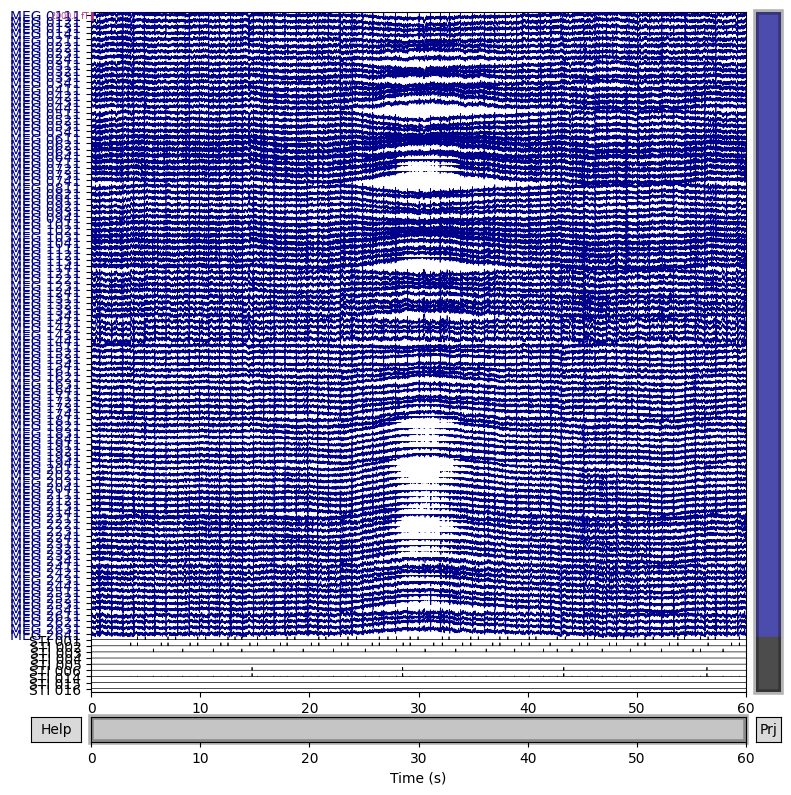

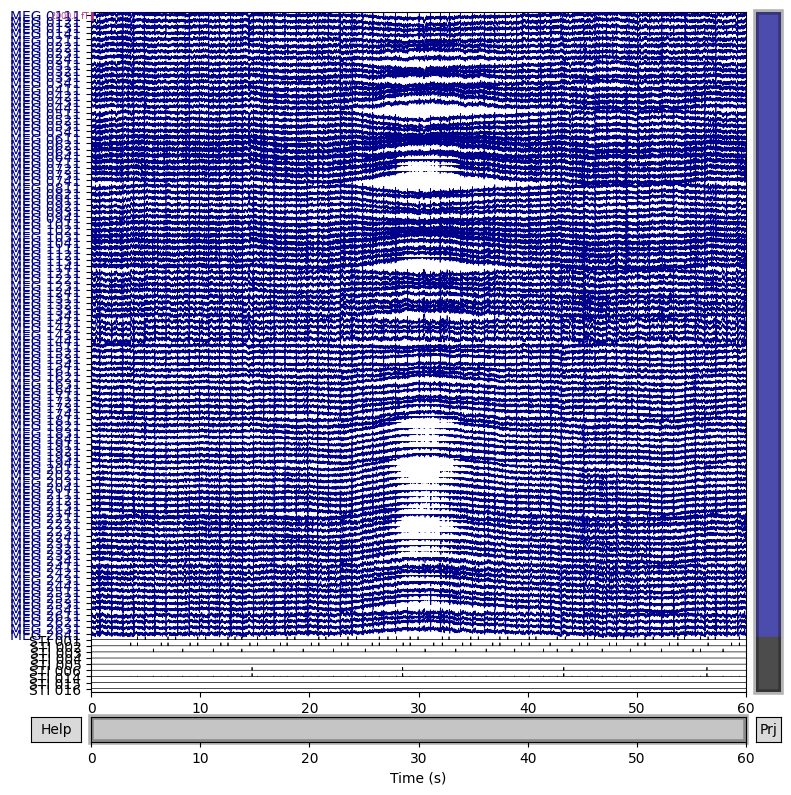

In [2]:
raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 19821 samples (33.001 s)



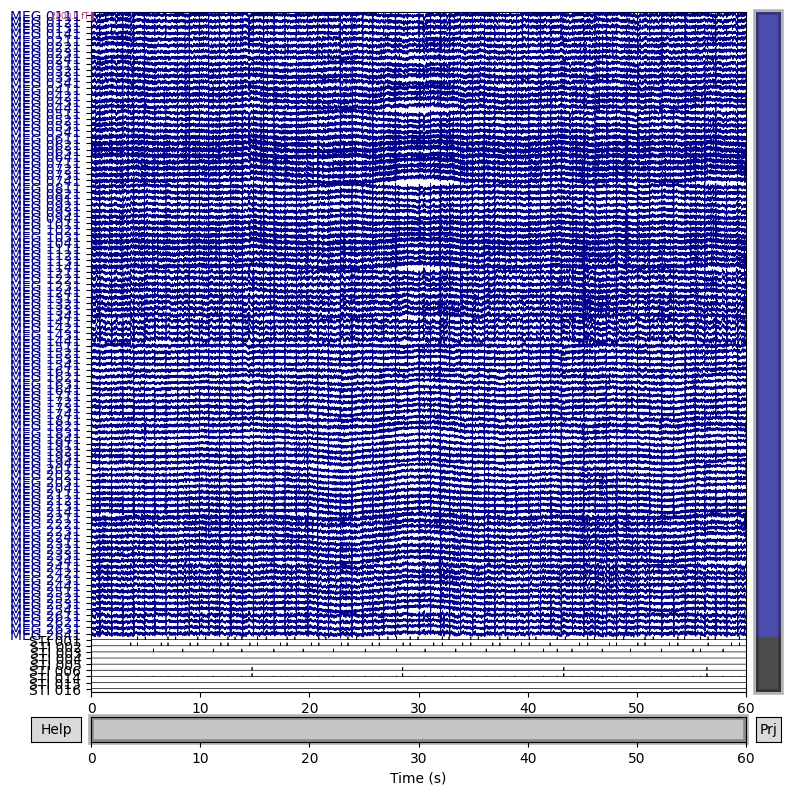

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 9911 samples (16.501 s)



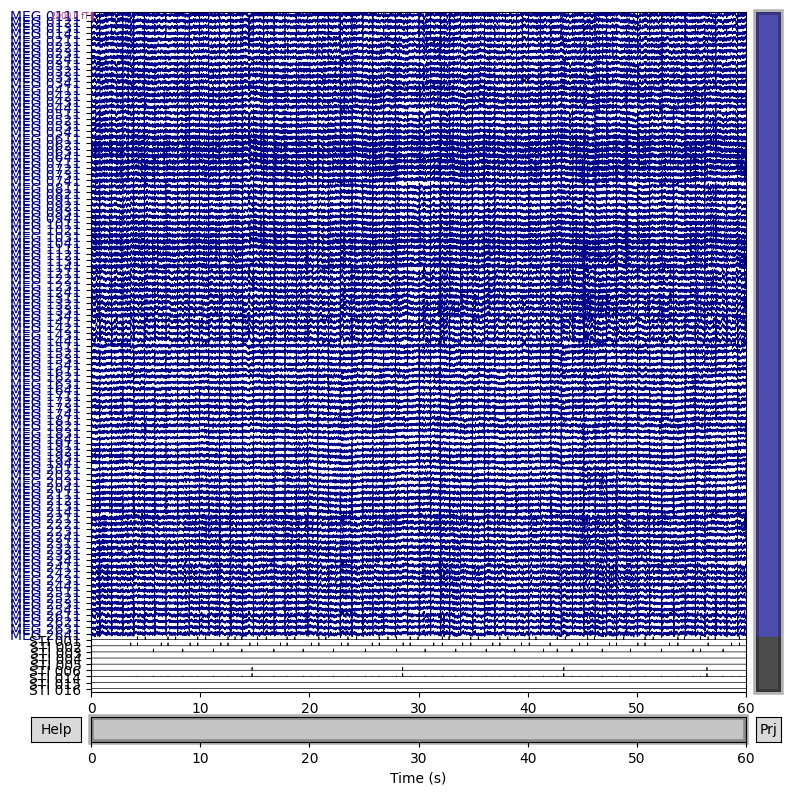

In [3]:
for cutoff in (0.1, 0.2):
    raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw_highpass.plot(
            duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=False
        )
    fig.subplots_adjust(top=0.9)
    fig.suptitle(f"High-pass filtered at {cutoff} Hz", size="xx-large", weight="bold")

In [4]:
filter_params = mne.filter.create_filter(
    raw.get_data(), raw.info["sfreq"], l_freq=0.2, h_freq=None
)

Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 9911 samples (16.501 s)



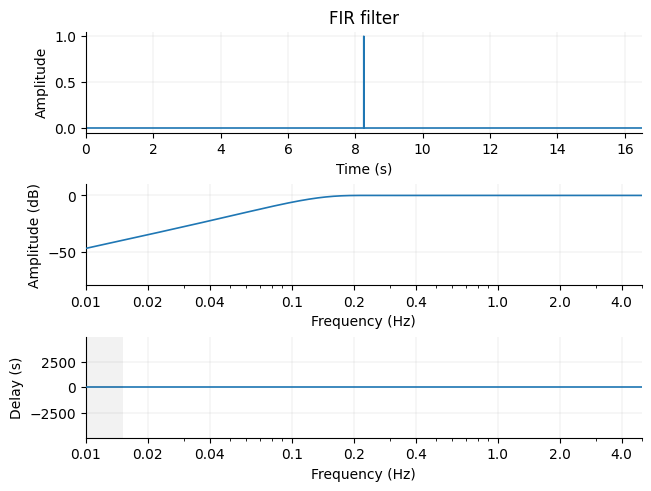

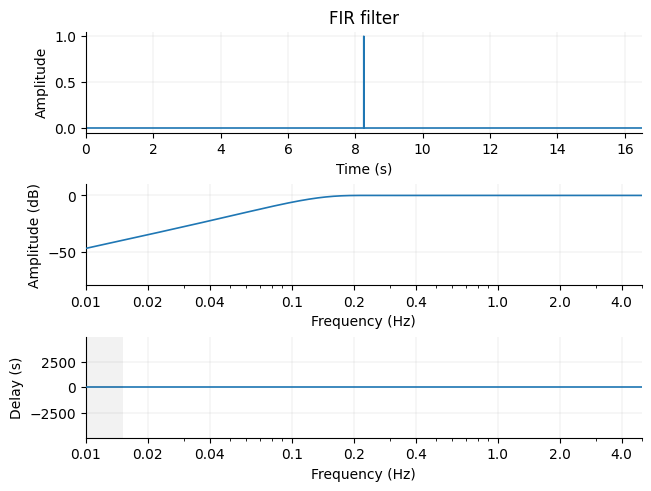

In [5]:
mne.viz.plot_filter(filter_params, raw.info["sfreq"], flim=(0.01, 5))

In [6]:
def add_arrows(axes):
    """Add some arrows at 60 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 120, 180, 240):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )


fig = raw.compute_psd(fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
add_arrows(fig.axes[:2])

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [7]:
meg_picks = mne.pick_types(raw.info, meg=True)
freqs = (60, 120, 180, 240)
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=meg_picks)
for title, data in zip(["Un", "Notch "], [raw, raw_notch]):
    fig = data.compute_psd(fmax=250).plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{title}filtered", size="xx-large", weight="bold")
    add_arrows(fig.axes[:2])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).
Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
